# Project: Comprehensive Analysis of 911 Emergency Calls
## Objective
The goal of this project is to analyze and model 911 emergency call data to gain insights into call patterns, identify high-demand locations, and predict future emergency trends. This can help local authorities optimize resource allocation and improve response times.

## Dataset
We’ll be using the 911 emergency call dataset, which contains various information about 911 calls, including the type of emergency, location, and timestamp.

### Importing Necessary Libraries

In [31]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and forecasting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from statsmodels.tsa.arima.model import ARIMA

# Clustering
from sklearn.cluster import KMeans

# Setting visualization styles
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)

# Setting a random seed for reproducibility
np.random.seed(42)


###  Loading and Inspecting the Data

In [32]:
# Load the dataset
df = pd.read_csv("../data/911.csv")

# Display basic information and the first few rows of the dataset
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423909 entries, 0 to 423908
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   lat        423909 non-null  float64
 1   lng        423909 non-null  float64
 2   desc       423909 non-null  object 
 3   zip        371780 non-null  float64
 4   title      423909 non-null  object 
 5   timeStamp  423909 non-null  object 
 6   twp        423750 non-null  object 
 7   addr       423909 non-null  object 
 8   e          423909 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 29.1+ MB
None


,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


### Data Cleaning and Preprocessing
The time-related features (hour, month, day of the week) and the emergency type are key for analysis. We extract these from existing columns, creating new features that will help in modeling and visualizations. Handling missing values ensures model integrity.

In [33]:
# Convert 'timeStamp' to datetime format
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

# Extract useful features from 'timeStamp'
df['Hour'] = df['timeStamp'].apply(lambda x: x.hour)
df['Month'] = df['timeStamp'].apply(lambda x: x.month)

dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['Day of Week'] = df['timeStamp'].apply(lambda t: t.dayofweek).map(dmap)

# Extract emergency category (e.g., EMS, Fire, Traffic) from the 'title' column
df['Category'] = df['title'].apply(lambda x: x.split(':')[0])

# Handle missing values by either filling or dropping them based on the feature's importance
df.dropna(subset=['zip', 'lat', 'lng'], inplace=True)

# Confirm the dataset after cleaning
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 371780 entries, 0 to 423908
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   lat          371780 non-null  float64       
 1   lng          371780 non-null  float64       
 2   desc         371780 non-null  object        
 3   zip          371780 non-null  float64       
 4   title        371780 non-null  object        
 5   timeStamp    371780 non-null  datetime64[ns]
 6   twp          371711 non-null  object        
 7   addr         371780 non-null  object        
 8   e            371780 non-null  int64         
 9   Hour         371780 non-null  int64         
 10  Month        371780 non-null  int64         
 11  Day of Week  371780 non-null  object        
 12  Category     371780 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 39.7+ MB


,lat,lng,desc,zip,title,timeStamp,twp,addr,e,Hour,Month,Day of Week,Category
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1,17,12,Thu,EMS
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1,17,12,Thu,EMS
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1,14,12,Thu,Fire
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1,16,12,Thu,EMS
5,40.253473,-75.283245,CANNON AVE & W 9TH ST; LANSDALE; Station 345;...,19446.0,EMS: HEAD INJURY,2015-12-10 15:39:04,LANSDALE,CANNON AVE & W 9TH ST,1,15,12,Thu,EMS


### Exploratory Data Analysis (EDA)
The EDA stage is crucial for identifying patterns and trends. The distribution of emergency types helps us understand the overall call landscape, while the heatmap and time series plot reveal how calls vary by time and date.

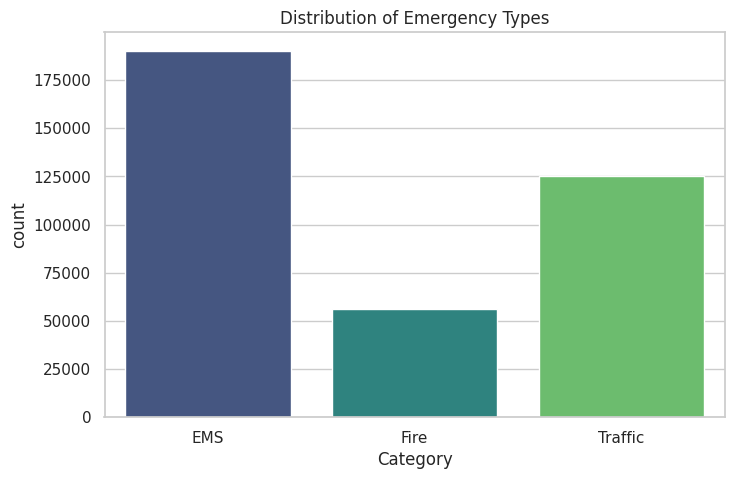

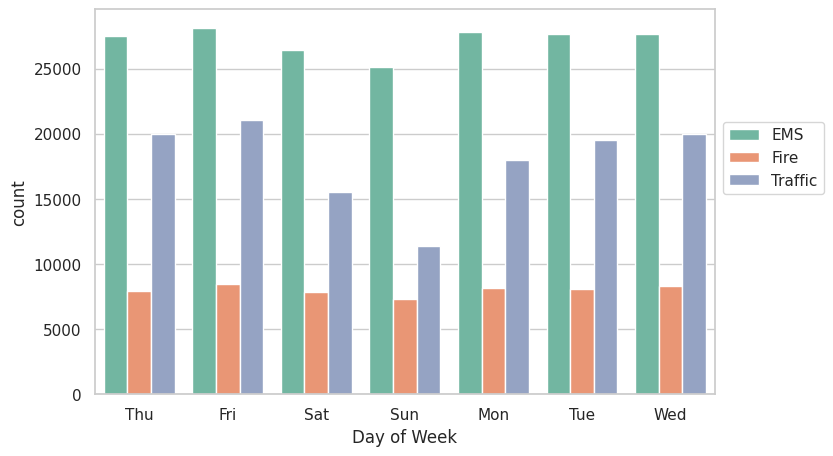

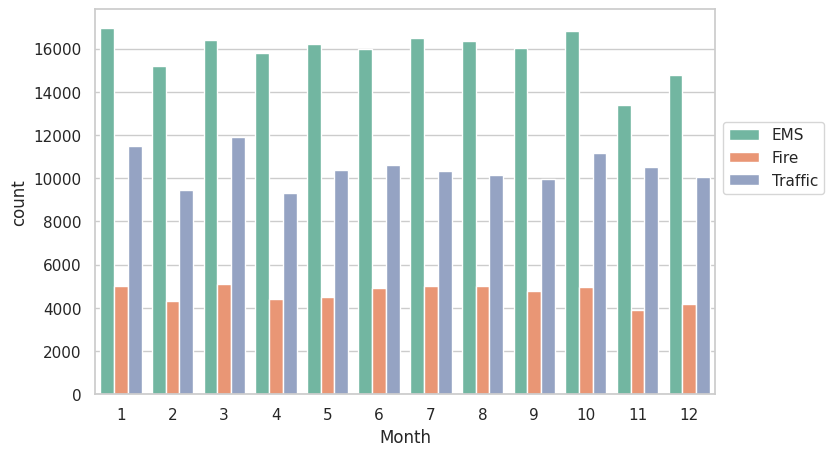

In [36]:
# Plotting the distribution of emergency types
sns.countplot(x='Category', data=df,hue='Category', legend=False, palette='viridis')
plt.title('Distribution of Emergency Types')
plt.show()


sns.countplot(x='Day of Week', data = df, hue = 'Category', palette = 'Set2')
plt.legend(loc='lower left',bbox_to_anchor=(1.0,0.5))
plt.show();

sns.countplot(x='Month', data = df, hue = 'Category', palette = 'Set2')
plt.legend(loc='lower left',bbox_to_anchor=(1.0,0.5))
plt.show();

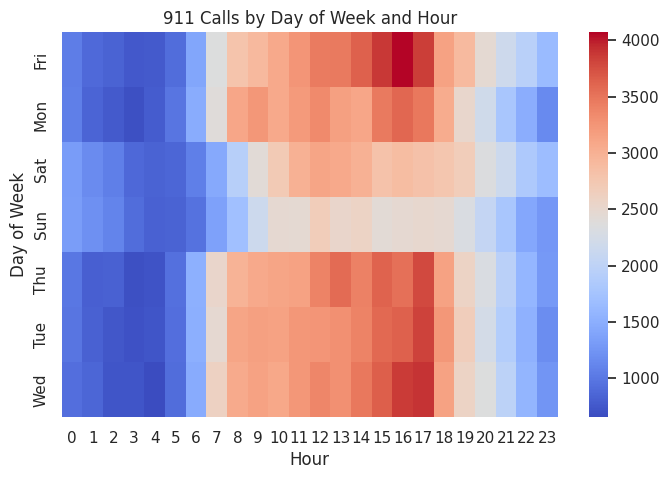

In [44]:
# Visualizing the number of 911 calls by day of the week and hour
calls_by_day_hour = df.groupby(['Day of Week', 'Hour']).count()['Category'].unstack()
sns.heatmap(calls_by_day_hour, cmap='coolwarm')
plt.title('911 Calls by Day of Week and Hour')
plt.show()



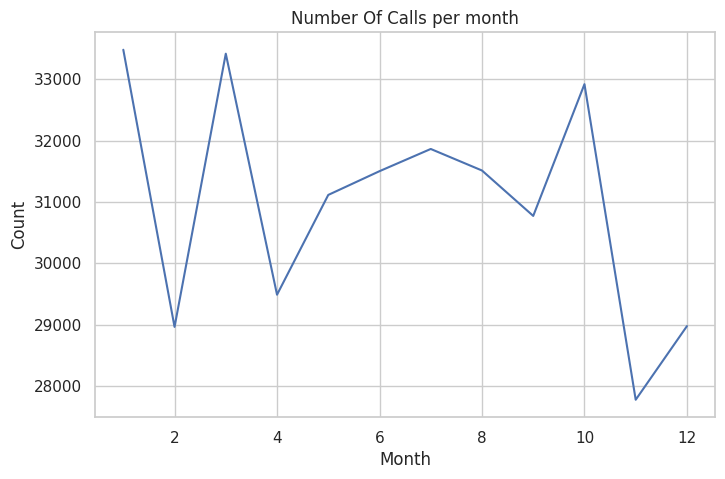

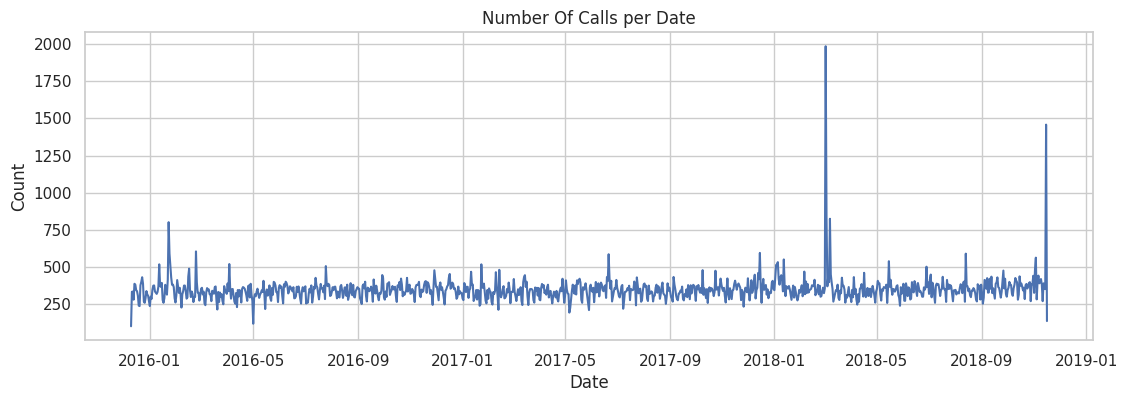

In [40]:
calls_per_month = df.groupby('Month').count()
sns.lineplot(x="Month", y="title", data=calls_per_month.reset_index()).set(
    title="Number Of Calls per month", ylabel='Count'
);

df['Date'] = pd.to_datetime(df.timeStamp.dt.date)
calls_per_date = df.groupby('Date').count()
plt.figure(figsize=(13,4))
sns.lineplot(x="Date", y="title", data=calls_per_date.reset_index()).set(
    title="Number Of Calls per Date", ylabel='Count');
plt.show();

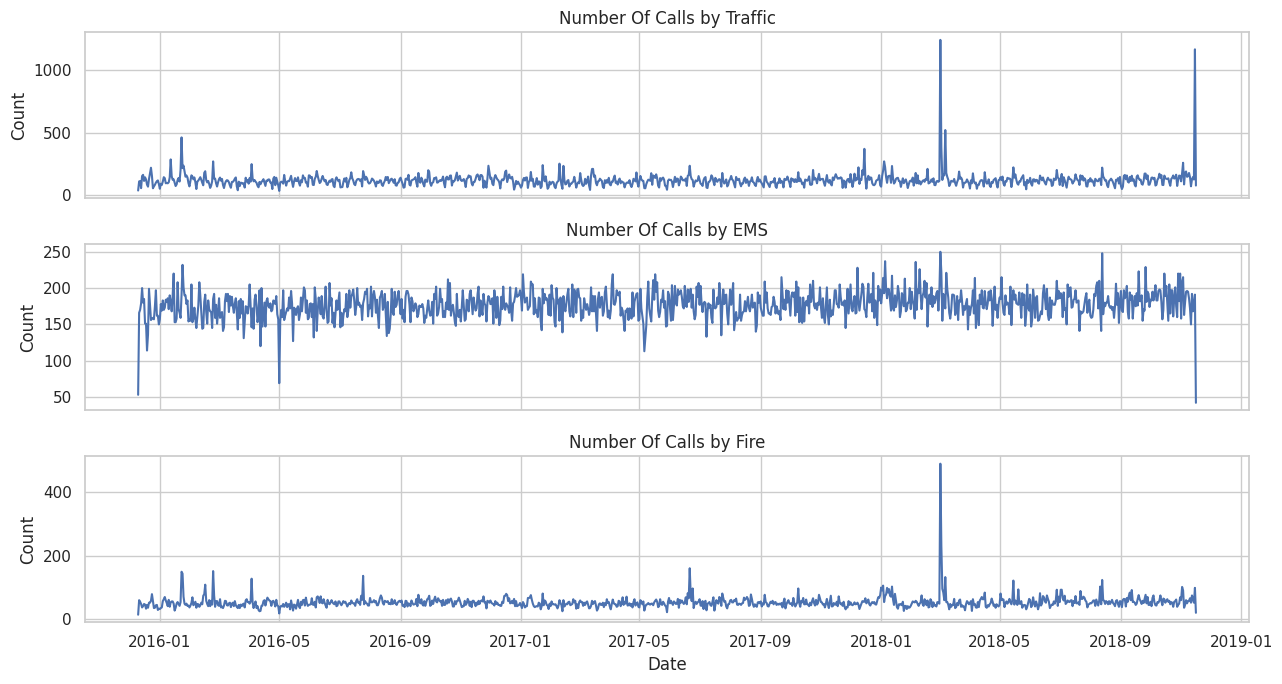

In [43]:
calls_per_month_by_reason = df.groupby(['Date','Category']).count().unstack()

fig, ax = plt.subplots(3, figsize=(13,7), sharex=True)

calls_by_traffic = calls_per_month_by_reason.title.unstack().loc['Traffic']
sns.lineplot(calls_by_traffic, ax=ax[0]).set(
    title="Number Of Calls by Traffic", ylabel="Count"
);


calls_by_ems = calls_per_month_by_reason.title.unstack().loc['EMS']

sns.lineplot(calls_by_ems, ax=ax[1]).set(
    title="Number Of Calls by EMS", ylabel="Count"
);

calls_by_fire = calls_per_month_by_reason.title.unstack().loc['Fire']

sns.lineplot(calls_by_fire, ax=ax[2]).set(
    title="Number Of Calls by Fire", ylabel="Count"
);
fig.tight_layout()

### Clustering Analysis
Clustering helps identify areas with high call volumes. This could be valuable for allocating emergency resources more efficiently. The scatter plot with K-means clusters visualizes geographical hotspots.

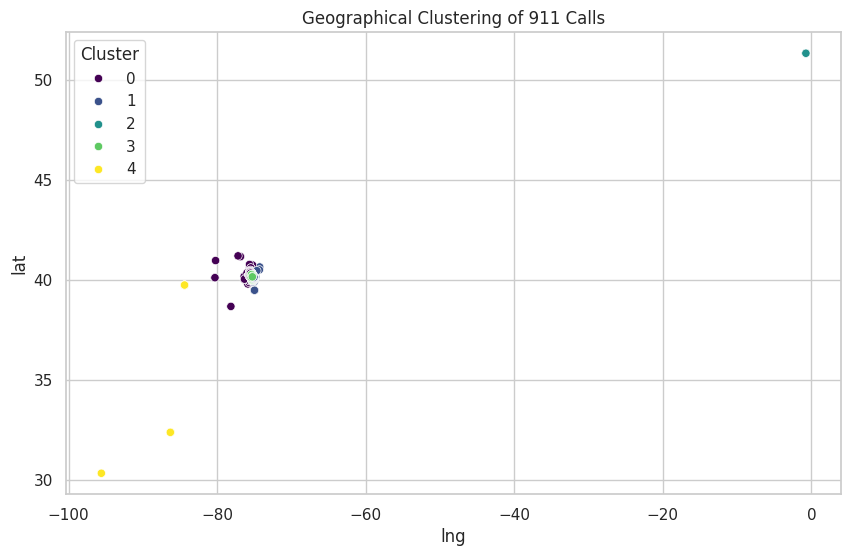

In [8]:
# Clustering based on geographical coordinates (lat, lng)
kmeans = KMeans(n_clusters=5)
df['Cluster'] = kmeans.fit_predict(df[['lat', 'lng']])

# Visualizing the clusters on a scatter plot
sns.scatterplot(x='lng', y='lat', hue='Cluster', data=df, palette='viridis')
plt.title('Geographical Clustering of 911 Calls')
plt.show()


### Time Series Forecasting
The ARIMA model is used for time series forecasting to predict future call volumes. This can help with resource planning and preparing for high-demand periods.

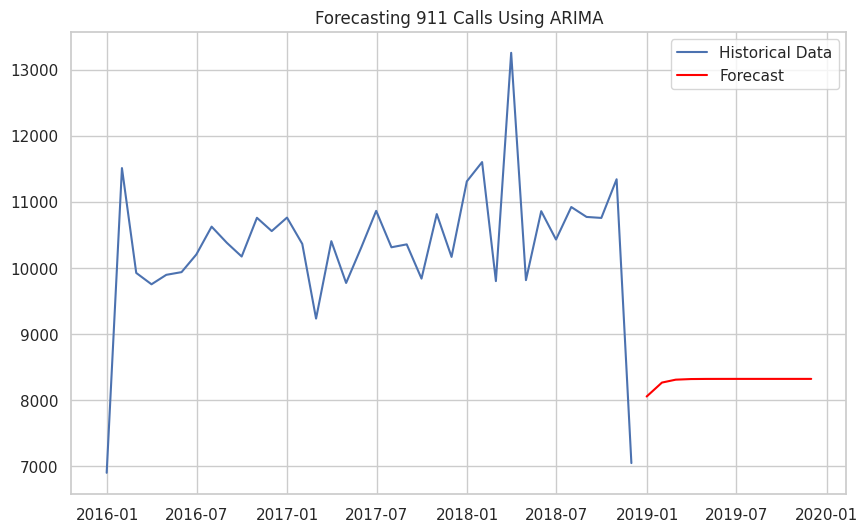

In [10]:
# Resampling data for monthly analysis
monthly_calls = df.resample('ME', on='timeStamp').count()['Category']

# ARIMA model for forecasting
model = ARIMA(monthly_calls, order=(1, 1, 1))
model_fit = model.fit()

# Forecasting the next 12 months
forecast = model_fit.forecast(steps=12)

# Plotting the forecast
plt.plot(monthly_calls.index, monthly_calls, label='Historical Data')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.title('Forecasting 911 Calls Using ARIMA')
plt.legend()
plt.show()


### Classification Model for Emergency Prediction

In [11]:
# Label encoding for categorical target variable
le = LabelEncoder()
df['Category_Encoded'] = le.fit_transform(df['Category'])

# Feature selection and train-test split
X = df[['lat', 'lng', 'Hour', 'Month', 'Day of Week']]
y = df['Category_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Building a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluating the model
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


              precision    recall  f1-score   support

           0       0.64      0.76      0.69     56822
           1       0.27      0.11      0.16     16888
           2       0.60      0.57      0.58     37824

    accuracy                           0.60    111534
   macro avg       0.50      0.48      0.48    111534
weighted avg       0.57      0.60      0.58    111534

Accuracy: 0.60
